In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
features = pd.read_csv('train.csv')
targets = features['Survived']
train, cvs, y_train, y_cvs = train_test_split(features, targets, test_size=0.4)
# train = pd.read_csv('train.csv')[:600]
# cvs = pd.read_csv('train.csv')[600:]
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,367231,7.7500,NaN,Q
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S
343,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


In [3]:
train['FarePerYear'] = train['Fare']/train['Age']
test['FarePerYear'] = test['Fare']/test['Age']
cvs['FarePerYear'] = cvs['Fare']/cvs['Age']
train['Worth'] = train['Age']/train['Pclass']
test['Worth'] = test['Age']/test['Pclass']
cvs['Worth'] = cvs['Age']/cvs['Pclass']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1035c82b0>,
      dtype=object)

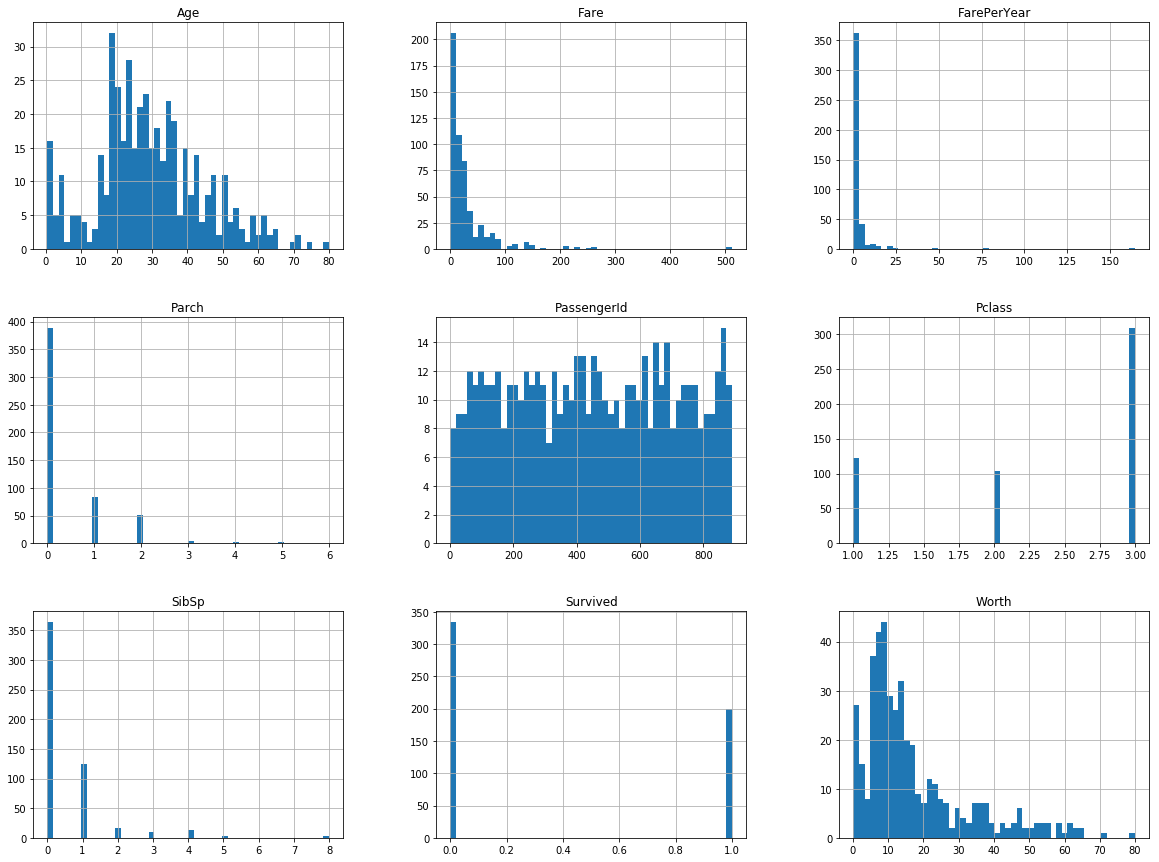

In [4]:
train.hist(bins=50, figsize=(20,15))

In [5]:
women = 0
total = 0
for index, row in train.iterrows():
    if row['Sex'] == 'female':
        women += row['Survived']
        total += 1
print(women/total)

0.7222222222222222


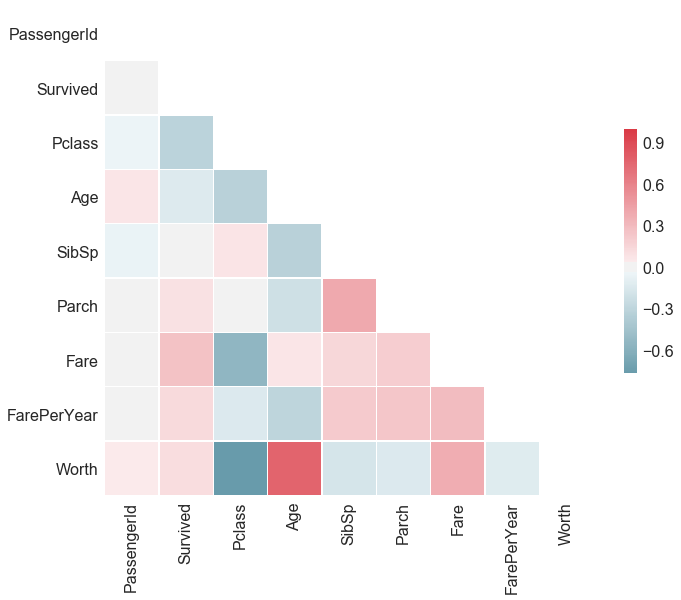

In [6]:
sns.set_style('white')
sns.set_context('paper', font_scale=2)
corr_matrix = train.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1.0, center=0,
           square=True, linewidths=0.5, cbar_kws={'shrink':0.5})

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["FarePerYear","Age", "SibSp", "Parch", "Fare"])),
        ("imputer", Imputer(strategy="median")),
    ])

In [9]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [10]:
from future_encoders import OneHotEncoder

cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [11]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [12]:
X_train = preprocess_pipeline.fit_transform(train)
y_train = train['Survived']
X_cv = preprocess_pipeline.fit_transform(cvs)
y_cv = cvs['Survived']
X_test = preprocess_pipeline.fit_transform(test)

In [13]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [2,3,4,5,10], 'n_estimators': [10,50,100,500],
    'min_child_weight': [1,2,3,5]}
]

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2, 3, 4, 5, 10], 'n_estimators': [10, 50, 100, 500], 'min_child_weight': [1, 2, 3, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
grid_search.best_params_

{'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 10}

In [24]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.48188145619821826 {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10}
0.4391854905744111 {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 50}
0.44553548978636487 {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
0.4660777450377519 {'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500}
0.48188145619821826 {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 10}
0.44553548978636487 {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 50}
0.44553548978636487 {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100}
0.47007848575693784 {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 500}
0.48188145619821826 {'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 10}
0.4391854905744111 {'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 50}
0.44131230926308423 {'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 100}
0.45592232730951643 {'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500}
0.48188145619821826 {'max_depth': 2, 

In [26]:
xgb_clf = grid_search.best_estimator_
from sklearn.metrics import accuracy_score

xgb_predictions = xgb_clf.predict(X_test)
accuracy = accuracy_score(xgb_clf.predict(X_cv), y_cv)
print('Training set accuracy:', accuracy)

Training set accuracy: 0.8235294117647058


In [28]:
d = {'PassengerId':[i+892 for i in range(len(list(xgb_predictions)))],
       'Survived': list(xgb_predictions)}
df = pd.DataFrame(data=d, index=None)
df.to_csv('xgb_cv_submission.csv', index=False)